# Random Forest - Optimized Model - Scores and Probabilities

# Import Modules

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# random state
random_state = 100

# Variables for plot sizes
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=14)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=14)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

# Import Data

In [2]:
# new feature dataframe
df_importance = pd.read_csv('data/df_clean_engineered_all.csv')

In [3]:
y = df_importance['churn']
df_importance = df_importance.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [4]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_halbjährlich',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_ZEIT Digital',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'anrede_Frau',
 'aboform_name_Geschenkabo',
 'unsubscribed_anzahl_1m',
 'studentenabo',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'opened_anzahl_bestandskunden_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_opened_1m',
 'kanal_andere',
 'kanal_B2B',
 'clicked_anzahl_6m',
 'che_reg',
 'MONTH_DELTA_nl_min',
 'zon_zp_red',
 'zahlung_rhythmus_name_vierteljährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'shop_kauf',
 'plz_2_10',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'openrate_3m',
 'openrate_1m',
 'nl_unsubscribed_6m',
 'nl_fdz_organisch',
 'metropole',
 'cnt_abo_magazin',
 'cnt_abo_diezeit_digital',
 'cnt_abo',
 'clicked_anzahl_bestandskunden_3m',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [5]:
df_importance = df_importance[important_features_combined_dropping]

In [6]:
X = df_importance

In [9]:
def train_predict(modelname, y_train, y_test, predictions_train, predictions_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - 
       - y_train: income training set
       -
       - y_test: income testing set
    '''
    
    results = {}
    
    # model name 
    results['model'] = modelname
    
    # accuracy
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # F1-score
    results['f1_train'] = f1_score(y_train,predictions_train)
    results['f1_test'] = f1_score(y_test,predictions_test) 
    
    # Recall
    results['recall_train'] = recall_score(y_train,predictions_train)
    results['recall_test'] = recall_score(y_test,predictions_test) 
    
    # Precision
    results['precision_train'] = precision_score(y_train,predictions_train)
    results['precision_test'] = precision_score(y_test,predictions_test) 
    
    # ROC AUC Score
    results['roc_auc_test'] = roc_auc_score(y_test,predictions_test)
    
    # Average Precison Score
    results['avg_precision_score'] = average_precision_score(y_test,predictions_test)
    
    # Return the results
    return results

In [95]:
def pipeline(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    models={
        # adjust parameters
        'randomforest':  RandomForestClassifier(n_jobs=-1,n_estimators=380, criterion='entropy',min_samples_split=4, min_samples_leaf=1, max_features='auto', max_depth=35,bootstrap=True,random_state=random_state),
    }  
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test','roc_auc_test','avg_precision_score'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        # fit model
        pipe.fit(X_train, y_train)

        #predict results
        #y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5, n_jobs=-1)
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)
        
        y_test_prob = pipe.predict_proba(X_test)[:,1] #only for churn == 1 since 1-prob(churn) = prob(no churn)
        
        ROC_curve = roc_curve(y_test, y_test_prob)
        PR_curve = precision_recall_curve(y_test, y_test_prob)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        
        conf_mat_pd = pd.crosstab(np.ravel(y_test), np.ravel(y_test_pred),
                               colnames=["Predicted"], rownames=["Actual"])
        sns.heatmap(conf_mat_pd, annot=True, cmap="Blues",fmt='d')
        plt.show()
        plt.close()
                                                
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        
        #print("\nConfusion matrix on test")
        #print(confusion_matrix(y_test, y_test_pred))
        #print("\n")
    return model_results, pipe, y_test_prob, y_test, ROC_curve, PR_curve, conf_matrix

## Call the pipeline

Undersampling
randomforest


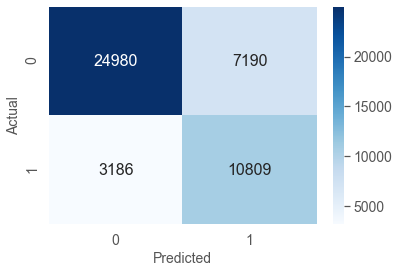

In [96]:
#get back the results of the model
model_results, pipe, y_test_prob, y_test, ROC_curve, PR_curve, conf_matrix = pipeline(X,y,balance='under')

In [112]:
model_results

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,roc_auc_test,avg_precision_score
0,randomforest,0.995844,0.775241,0.995839,0.675689,0.99476,0.772347,0.996921,0.600533,0.774424,0.532834


In [134]:
#model_results.reset_index(drop=True,inplace=True)

## Probability Plot

In [124]:
prob_df = pd.DataFrame(columns=['y_test','y_test_proba'])

In [125]:
prob_df['y_test'] = y_test

In [126]:
prob_df['y_test_proba'] = y_test_prob

In [127]:
prob_df

,y_test,y_test_proba
31004,0,0.090680
23867,0,0.279643
97361,0,0.437998
162161,1,0.556140
32071,1,0.712130
...,...,...
42509,0,0.253155
28057,0,0.310705
121997,0,0.471823
141959,0,0.698509


In [129]:
prob_df = prob_df.reset_index(drop=True)

### Histogram

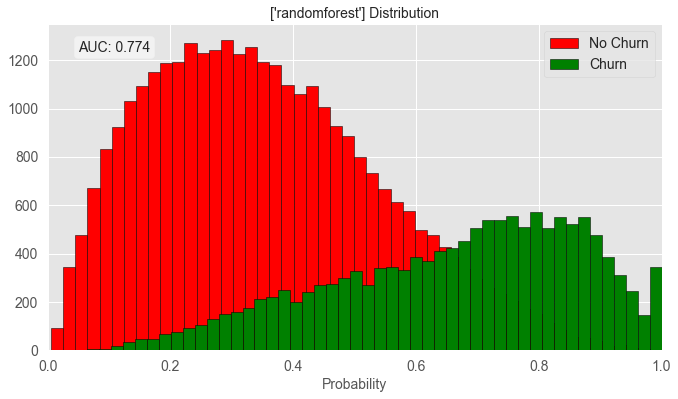

In [135]:
f, ax = plt.subplots(figsize=(11, 6), nrows=1, ncols = 1)
# Get AUC
textstr = f"AUC: {float(model_results.roc_auc_test.values):.3f}"

# Plot false distribution
false_pred = prob_df[prob_df['y_test'] == 0]
sns.distplot(false_pred['y_test_proba'], hist=True, kde=False, 
             bins=int(50), color = 'red', 
             hist_kws={'edgecolor':'black', 'alpha': 1.0},label='No Churn')

# Plot true distribution
true_pred = prob_df[prob_df['y_test'] == 1]
sns.distplot(true_pred['y_test_proba'], hist=True, kde=False, 
             bins=int(50), color = 'green',
             hist_kws={'edgecolor':'black', 'alpha': 1.0}, label='Churn')


# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Place a text box in upper left in axes coords
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment = "top", bbox=props)

# Set axis limits and labels
ax.set_title(f"{str(model_results.model.values)} Distribution")
ax.set_xlim(0,1)
ax.set_xlabel("Probability")
ax.legend();

### Density Plot

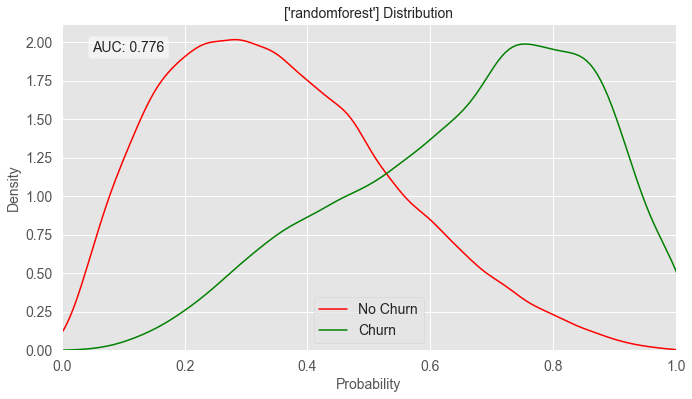

In [90]:
f, ax = plt.subplots(figsize=(11, 6), nrows=1, ncols = 1)
# Get AUC
textstr = f"AUC: {float(model_results.roc_auc_test.values):.3f}"

# Plot false distribution
false_pred = prob_df[prob_df['y_test'] == 0]
sns.distplot(false_pred['y_test_proba'], hist=False, kde=True, 
             bins=int(25), color = 'red', 
             hist_kws={'edgecolor':'black', 'alpha': 1.0},label='No Churn')

# Plot true distribution
true_pred = prob_df[prob_df['y_test'] == 1]
sns.distplot(true_pred['y_test_proba'], hist=False, kde=True, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black', 'alpha': 1.0}, label='Churn')


# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Place a text box in upper left in axes coords
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment = "top", bbox=props)

# Set axis limits and labels
ax.set_title(f"{str(model_results.model.values)} Distribution")
ax.set_xlim(0,1)
ax.set_xlabel("Probability")
ax.legend();

## ROC - AUC Curve

In [68]:
ROC_curve

(array([0.        , 0.        , 0.        , ..., 0.99981349, 0.99987566,
        1.        ]),
 array([0.        , 0.02072169, 0.02086459, ..., 1.        , 1.        ,
        1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99561404e-01, ...,
        3.81578947e-03, 2.70270270e-03, 1.31578947e-03]))

Text(0, 0.5, 'True Positive Rate')

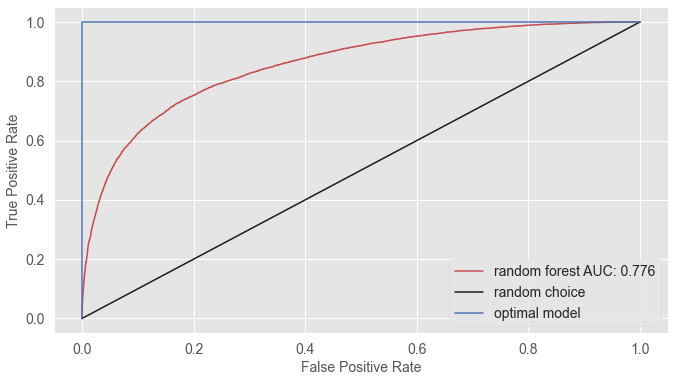

In [93]:
f, ax = plt.subplots(figsize=(11, 6), nrows=1, ncols = 1)
plt.plot(ROC_curve[0],ROC_curve[1],'r-',label = 'random forest AUC: %.3f'%float(model_results.roc_auc_test.values))
plt.plot([0,1],[0,1],'k-',label='random choice')
plt.plot([0,0,1,1],[0,1,1,1],'b-',label='optimal model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Precision Recall Curve

In [77]:
average_precision = average_precision_score(y_test, y_test_prob)

In [78]:
average_precision

0.7531670332931614

In [76]:
PR_curve

(array([0.30497505, 0.3049599 , 0.30496655, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.99992855, 0.99992855, ..., 0.02086459, 0.02072169,
        0.        ]),
 array([0.03723684, 0.03730263, 0.03741228, ..., 0.99934211, 0.9995614 ,
        1.        ]))

Text(0, 0.5, 'Precision')

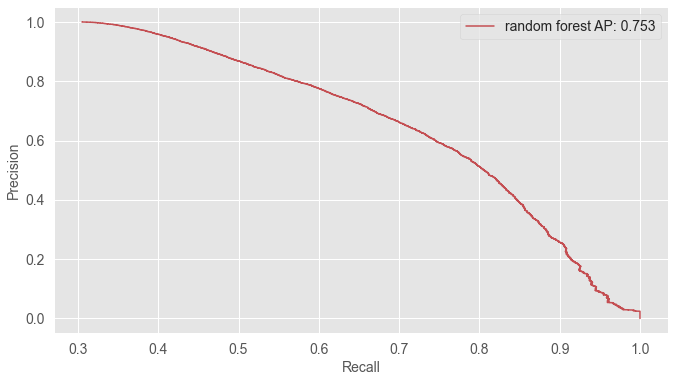

In [85]:
f, ax = plt.subplots(figsize=(11, 6), nrows=1, ncols = 1)
plt.plot(PR_curve[0], PR_curve[1],'r-',label = 'random forest AP: %.3f'%average_precision)
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')